<a href="https://colab.research.google.com/github/vkt1414/mhubai-unleashed/blob/main/src/radiomics_notebook/mhub_dicomsegAndRadiomicsSR_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook generates DICOM Seg objects and DICOM Structured Reports with Segmentation Maps and the corresponding csv manifest containing the download urls to CT DICOM files as the input**

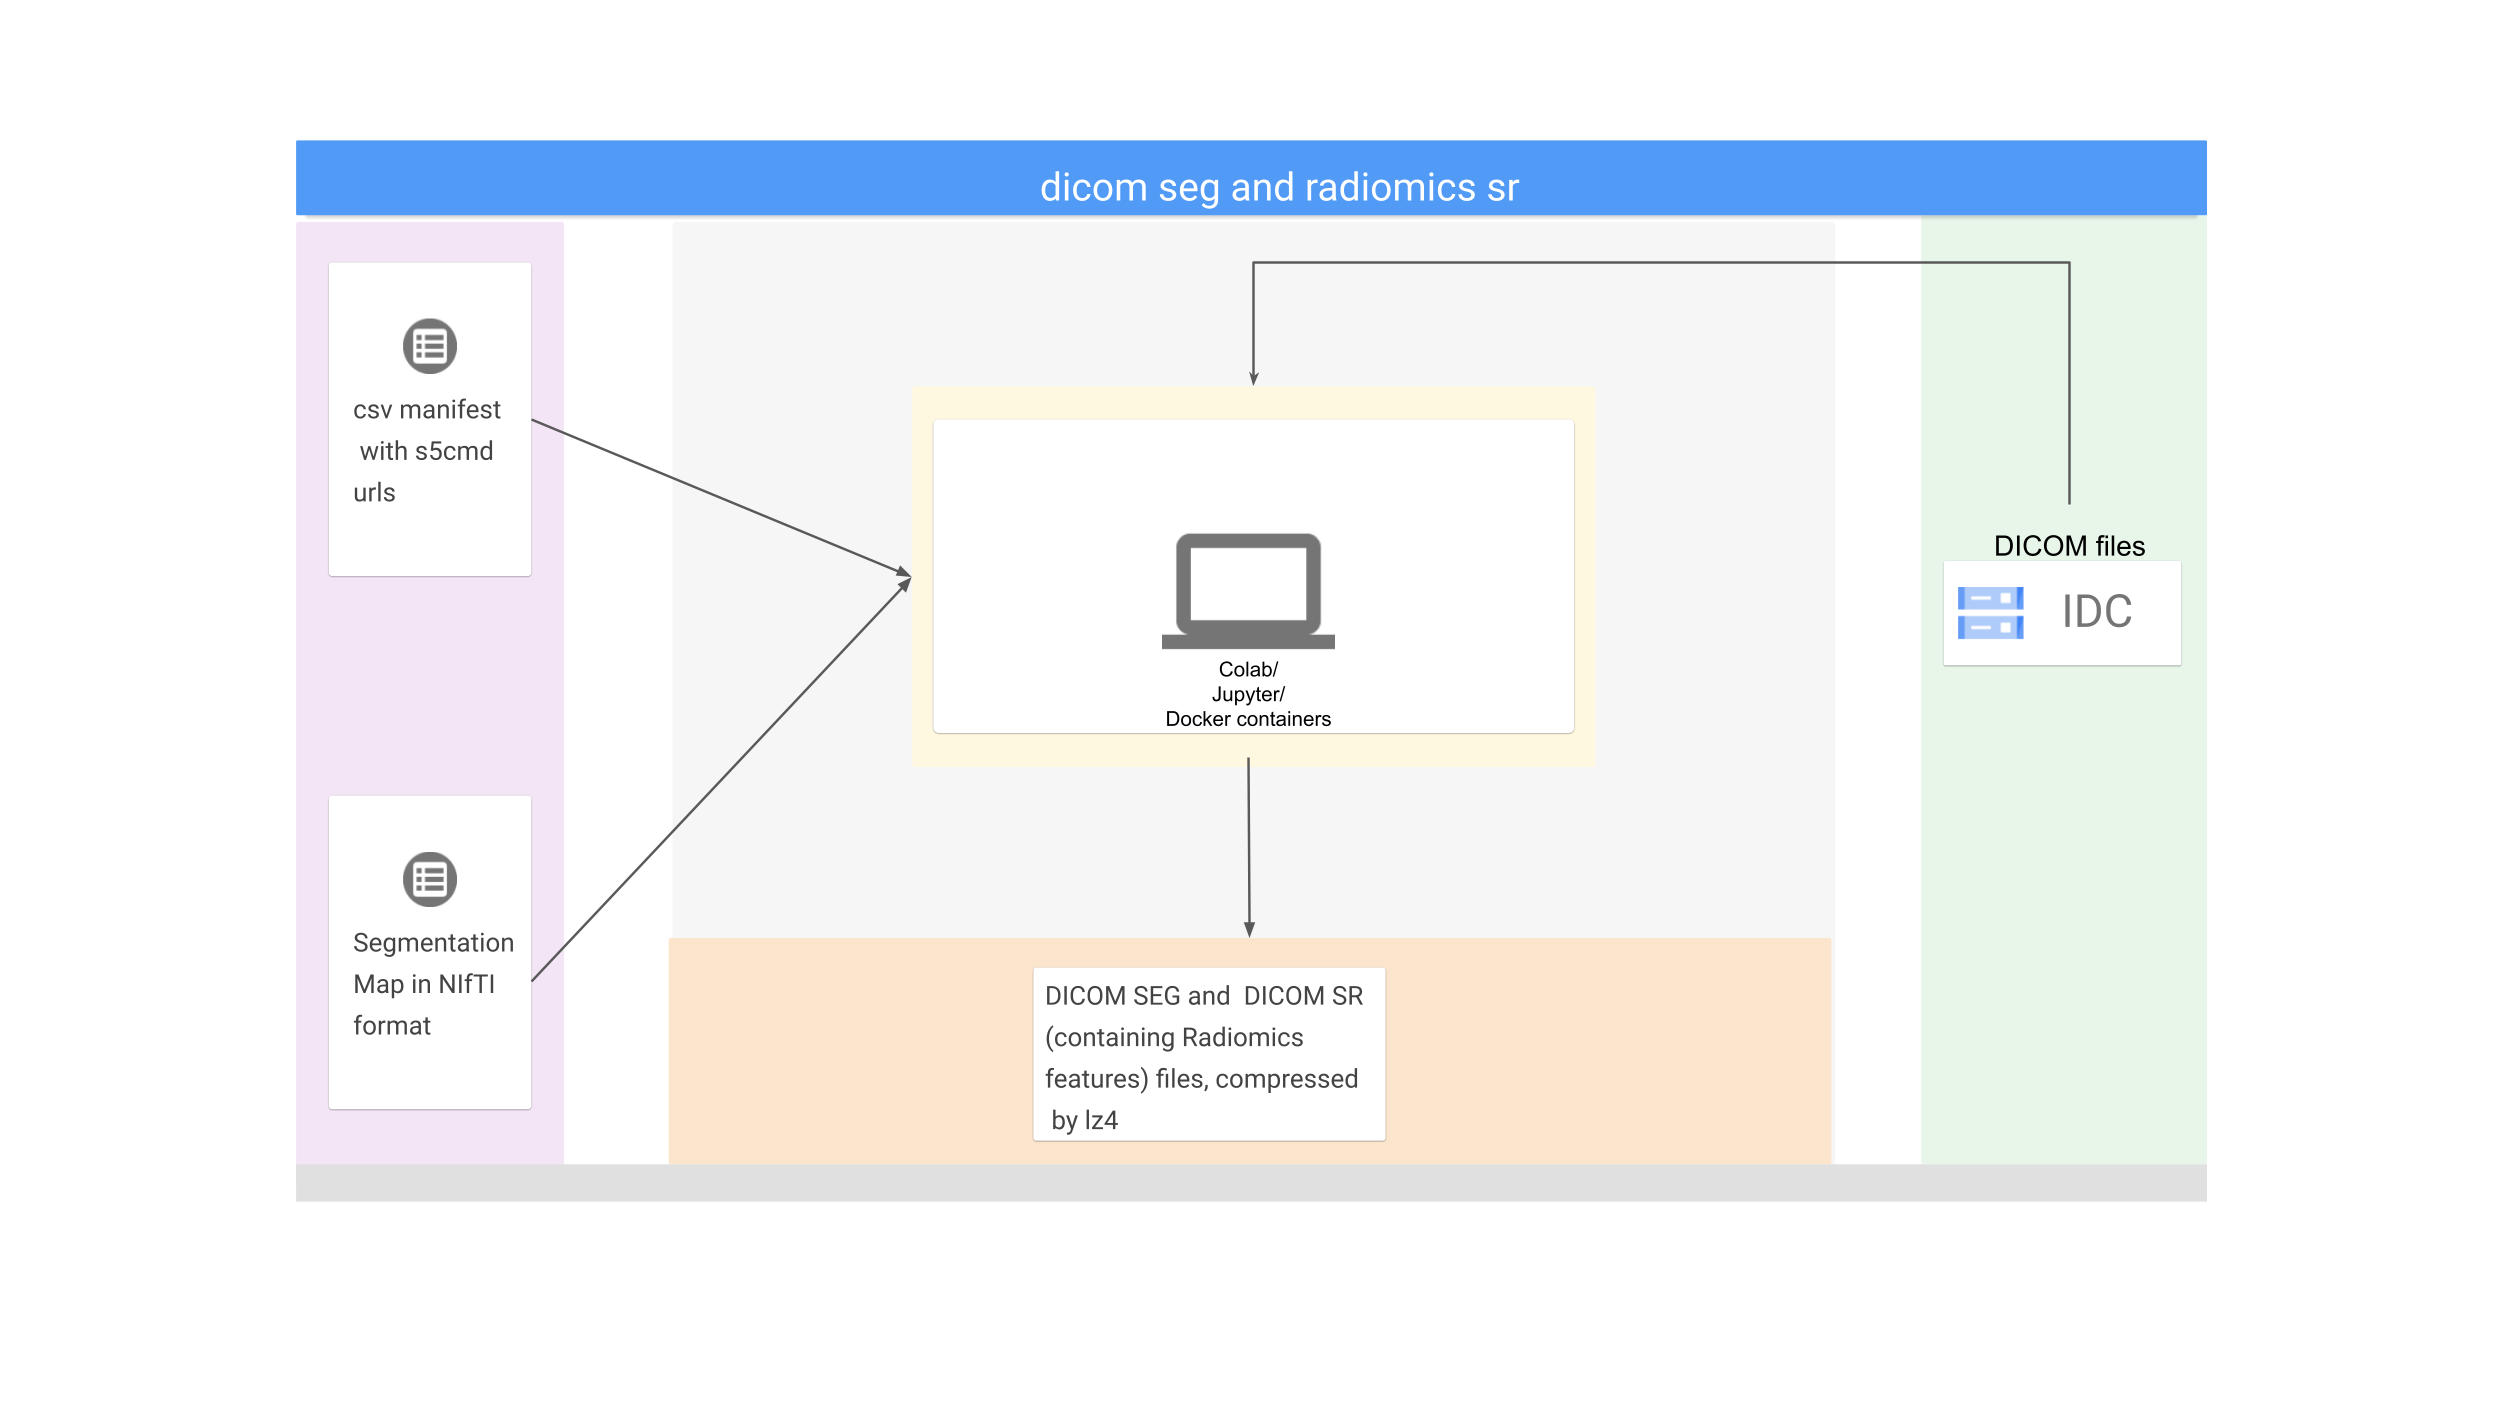

Please cite:

Herz C, Fillion-Robin JC, Onken M, Riesmeier J, Lasso A, Pinter C, Fichtinger G, Pieper S, Clunie D, Kikinis R, Fedorov A. dcmqi: An Open Source Library for Standardized Communication of Quantitative Image Analysis Results Using DICOM. Cancer Res. 2017 Nov 1;77(21):e87-e90. doi: 10.1158/0008-5472.CAN-17-0336. PMID: 29092948; PMCID: PMC5675033.

Li X, Morgan PS, Ashburner J, Smith J, Rorden C. (2016) The first step for neuroimaging data analysis: DICOM to NIfTI conversion. J Neurosci Methods. 264:47-56.

Fedorov, A., Longabaugh, W. J. R., Pot, D., Clunie, D. A., Pieper, S., Aerts, H. J. W. L., Homeyer, A., Lewis, R., Akbarzadeh, A., Bontempi, D., Clifford, W., Herrmann, M. D., Höfener, H., Octaviano, I., Osborne, C., Paquette, S., Petts, J., Punzo, D., Reyes, M., Schacherer, D. P., … Kikinis, R. (2021). NCI Imaging Data Commons. Cancer research, 81(16), 4188–4193. https://doi.org/10.1158/0008-5472.CAN-21-0950

Expected file directory
```
output_data/
 └─── $series_id_1
       ├─── segmentations.nii.gz
       │
 └───  $series_id_2
       ├─── segmentations.nii.gz
       ├───  ...
       │
 └───  $series_id_n
       └─── segmentations.nii.gz

```

###**Ways to utilize this notebook**


*   **Colab**
*   **Jupyter Notebook/Lab**
*   **DockerContainer/Terra/SB-CGC**


####**Colab**
*  This notebook was initally developed and tested on Colab, and a working version is saved on github
*  To run this notebook with Colab, Click 'Open In Colab' icon on top left 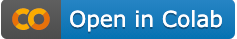
*Uncomment all the cells under "Installing Packages"
*Provide the path to lz4 compressed file containing Segmentation NIfTI files as shown 'Expected file directory' under "Parameters for Papermill"
*Provide the path to csv manifest containing corresponding SeriesInstanceUID and s5cmd download urls (specific to IDC aws buckets) under "Parameters for Papermill"
* A sample file containing the segmentation maps and corresponding csv manifest is provided for convenience can be downloaded by uncommenting and running the cells in "For local testing"
* The CSV manifest expects a SeriesInstanceUID and s5cmd url to download the entire series to **/app/data/input_data/SeriesInstanceUID(or any unique id for a series)**. The manifest may contain any other metadata if needed.
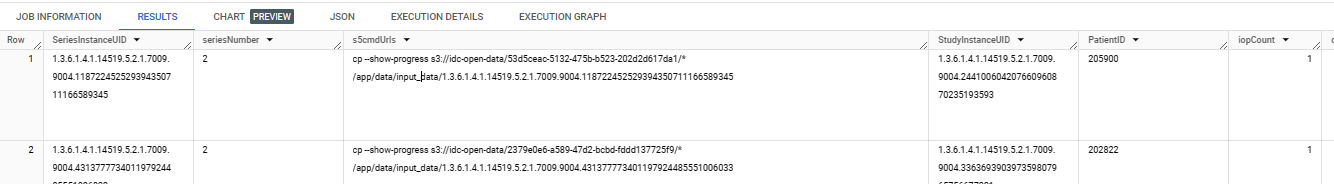
* Run each cell to install the packages and to decompress the segmentation maps, and to download the CT data from IDC, convert to NIfTI, write DICOM Seg and DICOM SR files saved in lz4 compressed format

####**Docker**
* This notebook is saved by default in a way that's amenable to be used on Terra/SB-CGC platforms using Docker
* Running this notebook in a docker container ensures reproduciblity, as we lock the run environment beginning from the base docker image to apt packages and pip packages in the docker image

* Docker images can be found @ https://hub.docker.com/repository/docker/imagingdatacommons/radiomics/tags
* The link to dockerfile along with git commit hash used for building the docker image can be found in one of the layers called 'LABEL'
* We use a python package called Papermill, that can run the notebook with out having to convert it to python script. This allows us maintain one copy of code instead of two.
* To use papermill, download this notebook and tag the cell under 'Parameters for Papermill" as parameters using jupyternotebook or jupyterlab as instructed @ https://papermill.readthedocs.io/en/latest/usage-parameterize.html#designate-parameters-for-a-cell
* A sample papermill command is
<pre>
papermill -p csvFilePath path_to_csv_manifest.csv -p inferenceNiftiFilePath path_to_inference_nifti_files.lz4 mhub_dicomsegAndRadiomicsSR_Notebook.ipynb mhub_outputdicomsegAndRadiomicsSR_Notebook.ipynb
</pre>




###**Installing Packages**

In [ ]:
# %%capture
# !sudo apt-get update \
#   && apt-get install -y --no-install-recommends \
#     build-essential\
#     lz4\
#     pigz\
#     python3-dev\
#     unzip\
#     wget\
#     zip\
#   && rm -rf /var/lib/apt/lists/*

In [ ]:
# %%capture
# !sudo pip3 install --no-cache-dir \
#     highdicom==0.21.1\
#     ipykernel==6.22.0\
#     ipython==8.11.0\
#     ipywidgets==8.0.5\
#     jupyter==1.0.0\
#     matplotlib==3.7.1\
#     nibabel==5.1.0\
#     pandas==1.5.3\
#     papermill==2.4.0\
#     p_tqdm==1.4.0\
#     pydicom==2.4.1\
#     tqdm==4.65.0\
#  && pip install --no-cache-dir \
#     pyradiomics==3.0.1

In [ ]:
# %%capture
# !wget "https://github.com/rordenlab/dcm2niix/releases/download/v1.0.20230411/dcm2niix_lnx.zip" \
#   && unzip "dcm2niix_lnx.zip" \
#   && rm "dcm2niix_lnx.zip" \
#   && mv dcm2niix /usr/local/bin/dcm2niix

In [ ]:
# %%capture
# dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.3.0/dcmqi-1.3.0-linux.tar.gz"
# dcmqi_download_path = f"dcmqi-1.3.0-linux.tar.gz"
# dcmqi_path = f"dcmqi-1.3.0-linux"
# !wget -O $dcmqi_download_path $dcmqi_release_url\
#   && tar -xvf $dcmqi_download_path\
#   && mv $dcmqi_path/bin/* /bin\
#   && rm -r $dcmqi_download_path $dcmqi_path

In [ ]:
# %%capture
# #install s5cmd
# !wget "https://github.com/peak/s5cmd/releases/download/v2.2.2/s5cmd_2.2.2_Linux-64bit.tar.gz"
# !tar -xvzf "s5cmd_2.2.2_Linux-64bit.tar.gz"\
#   && rm "s5cmd_2.2.2_Linux-64bit.tar.gz"\
#   && mv s5cmd /usr/local/bin/s5cmd\
#   && rm CHANGELOG.md LICENSE README.md

###**Importing Packages**

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
from functools import partial
import glob
import json
import logging
import matplotlib.pyplot as plt
import multiprocessing
import nibabel as nib
import numpy as np
import os
from pathlib import Path
import pandas as pd
import psutil
import pydicom
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes
from pydicom.uid import generate_uid
import radiomics
from radiomics import featureextractor, generalinfo
import random
import re
import shutil
import SimpleITK as sitk
import subprocess
import sys
import time
from time import sleep, asctime, localtime
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

###**Current Environment**

In [ ]:
#echo current environment
curr_dir = Path().absolute()
print(asctime(localtime()))
print("\nCurrent directory :{}".format(curr_dir))
print("Python version :", sys.version.split("\n")[0])

Fri Dec  8 02:34:29 2023

Current directory :/content
Python version : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


###**Parameters for running this notebook with Papermill python package in cloud**

In [ ]:
#csv and inference file paths are provided as input when running on cloud
csvFilePath=''
inferenceNiftiFilePath=''

###**Input files for local testing**

In [ ]:
# try:
#   os.remove(f'{curr_dir}/mhubai_batch_1.csv')
#   os.remove(f'{curr_dir}/output.tar.lz4')
# except OSError:
#   pass

# !wget -q https://raw.githubusercontent.com/vkt1414/mhubai-unleashed/main/src/test/mhubai_batch_1.csv
# csvFilePath = glob.glob('*.csv')[0]

# !wget -q https://github.com/vkt1414/mhubai-unleashed/raw/main/src/test/output.tar.lz4
# #Get the file path of the inferenceNiftiFiles
# inferenceNiftiFilePath=glob.glob('*.lz4')[0]

###**Extracting Inference NIFTI files**

In [ ]:
# Be default inference files are compressed with lz4, a fast compression/decompression tool
try:
    shutil.rmtree(f"output_data")
except OSError:
    pass
!lz4 -d --rm {inferenceNiftiFilePath} -c | tar --strip-components=0 -xvf -

output_data/
output_data/1.2.840.113654.2.55.113040386178547843571271236478024341696/
output_data/1.2.840.113654.2.55.113040386178547843571271236478024341696/segmentations.nii.gz
output_data/1.2.840.113654.2.55.216614002338888733987350522981366678482/
output_data/1.2.840.113654.2.55.216614002338888733987350522981366678482/segmentations.nii.gz
output_data/1.2.840.113654.2.55.142419057730651121165090739113900499978/
output_data/1.2.840.113654.2.55.142419057730651121165090739113900499978/segmentations.nii.gz
output_data/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/
output_data/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/segmentations.nii.gz
output_data/1.2.840.113654.2.55.243990451406006403331425809632881193215/
output_data/1.2.840.113654.2.55.243990451406006403331425809632881193215/segmentations.nii.gz
output_data/1.2.840.113654.2.55.185309182591805634517860395342326800332/
output_data/1.2.840.113654.2.55.185309182591805634517860395342326800332/se

###**Reading CSV File containing s5cmd Urls**

In [ ]:
cohort_df = pd.read_csv(csvFilePath, delimiter=",", encoding="utf-8")

cohort_df

,SeriesInstanceUID,seriesNumber,s5cmdUrls,StudyInstanceUID,PatientID,iopCount,dotProduct,pixelSpacingCount,positionCount,sopInstanceCount,...,pixelColumnCount,maxSliceIntervalDifference,minSliceIntervalDifference,sliceIntervalifferenceTolerance,exposureCount,maxExposure,minExposure,maxExposureDifference,seriesSizeInMB,viewerUrl
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529...,2,cp --show-progress s3://idc-open-data/53d5ceac...,1.3.6.1.4.1.14519.5.2.1.7009.9004.244100604207...,205900,1,1.0,1,181,181,...,1,2.000016,1.999969,0.000047,1,1147.0,1147.0,0.0,90.968382,https://viewer.imaging.datacommons.cancer.gov/...
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401...,2,cp --show-progress s3://idc-open-data/2379e0e6...,1.3.6.1.4.1.14519.5.2.1.7009.9004.336369390397...,202822,1,1.0,1,115,115,...,1,2.500030,2.499985,0.000045,2,444.0,55.0,389.0,57.795650,https://viewer.imaging.datacommons.cancer.gov/...
2,1.2.840.113654.2.55.10087518978221069034420730...,2,cp --show-progress s3://idc-open-data/289cc6e5...,1.2.840.113654.2.55.27974279760824218532125143...,107030,1,1.0,1,135,135,...,1,2.500016,2.499992,0.000024,1,1440.0,1440.0,0.0,67.796879,https://viewer.imaging.datacommons.cancer.gov/...
3,1.2.840.113654.2.55.11304038617854784357127123...,2,cp --show-progress s3://idc-open-data/33aa3ae8...,1.2.840.113654.2.55.17095416084202608225620839...,128156,1,1.0,1,191,191,...,1,2.000008,1.999984,0.000024,1,1680.0,1680.0,0.0,95.929247,https://viewer.imaging.datacommons.cancer.gov/...
4,1.2.840.113654.2.55.14241905773065112116509073...,3,cp --show-progress s3://idc-open-data/bed1988c...,1.2.840.113654.2.55.24234478010817068552373501...,119129,1,1.0,1,128,128,...,1,2.500008,2.499984,0.000024,1,1530.0,1530.0,0.0,64.283251,https://viewer.imaging.datacommons.cancer.gov/...
5,1.2.840.113654.2.55.14382674871619950799472325...,2,cp --show-progress s3://idc-open-data/4a5a70a4...,1.2.840.113654.2.55.12545552805714121337066865...,105142,1,1.0,1,122,122,...,1,2.500008,2.499984,0.000024,1,1360.0,1360.0,0.0,61.268053,https://viewer.imaging.datacommons.cancer.gov/...
6,1.2.840.113654.2.55.14660159465432299498263001...,2,cp --show-progress s3://idc-open-data/367108f7...,1.2.840.113654.2.55.13440616151556421903161182...,106553,1,1.0,1,139,139,...,1,2.500016,2.499992,0.000024,1,966.0,966.0,0.0,69.807289,https://viewer.imaging.datacommons.cancer.gov/...
7,1.2.840.113654.2.55.15480970559124215907525360...,2,cp --show-progress s3://idc-open-data/ae1271a1...,1.2.840.113654.2.55.10316836565080352970150093...,126576,1,1.0,1,112,112,...,1,2.500008,2.499984,0.000024,1,1200.0,1200.0,0.0,56.248404,https://viewer.imaging.datacommons.cancer.gov/...
8,1.2.840.113654.2.55.18530918259180563451786039...,2,cp --show-progress s3://idc-open-data/f1df8e90...,1.2.840.113654.2.55.32925722693090382799215706...,118560,1,1.0,1,158,158,...,1,2.000008,1.999984,0.000024,1,1020.0,1020.0,0.0,79.355711,https://viewer.imaging.datacommons.cancer.gov/...
9,1.2.840.113654.2.55.21661400233888873398735052...,3,cp --show-progress s3://idc-open-data/ec05d305...,1.2.840.113654.2.55.30817051707988585379259683...,132036,1,1.0,1,130,130,...,1,2.500008,2.499984,0.000024,1,1200.0,1200.0,0.0,65.286131,https://viewer.imaging.datacommons.cancer.gov/...


###**Prepare Intial Directories**

In [ ]:
try:
  shutil.rmtree(f'itkimage2segimage')
  shutil.rmtree(f'radiomics')
  shutil.rmtree(f'dcm2niix')
  shutil.rmtree(f'structuredReportsDICOM')
  shutil.rmtree(f'structuredReportsJSON')
  shutil.rmtree(f'jsonConfigs')
except OSError:
  pass

os.mkdir(f'itkimage2segimage')
os.mkdir(f'radiomics')
os.mkdir(f'dcm2niix')
os.mkdir(f'structuredReportsDICOM')
os.mkdir(f'structuredReportsJSON')
os.mkdir(f'jsonConfigs')

###**Helper Functions**

In [ ]:
try:
  os.remove(f'{curr_dir}/dicomseg_metadata_whole_slicerAsRef.json')
  os.remove(f'{curr_dir}/map_to_binary.py')
except OSError:
  pass
!wget https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/config_fix/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
!wget https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/totalsegmentator/map_to_binary.py
import map_to_binary

--2023-12-08 02:34:30--  https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/config_fix/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99157 (97K) [text/plain]
Saving to: ‘dicomseg_metadata_whole_slicerAsRef.json’

dicomseg_metadata_w 100%[===================>]  96.83K  --.-KB/s    in 0.01s   

2023-12-08 02:34:30 (7.61 MB/s) - ‘dicomseg_metadata_whole_slicerAsRef.json’ saved [99157/99157]

--2023-12-08 02:34:30--  https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/totalsegmentator/map_to_binary.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercont

In [ ]:
totalsegmentator_segments_code_mapping_df=pd.read_csv('https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/config_fix/configs/TotalSegmentator/TotalSegmentator%20v1%20SCT%20mapping%20-%20total.csv',index_col=[0], dtype={'SegmentedPropertyTypeModifierCodeSequence.CodeValue': str})
totalsegmentator_radiomics_features_code_mapping_df=pd.read_csv('https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/config_fix/configs/TotalSegmentator/radiomicsFeaturesMaps.csv',index_col=[0])
totalsegmentator_radiomics_features_code_mapping_df


,feature,pyradiomics_feature_class,pyradiomics_notes,quantity_CodingSchemeDesignator,quantity_CodeValue,quantity_CodeMeaning,units_CodingSchemeDesignator,units_CodeValue,units_CodeMeaning
0,Elongation,shape,NaN,IBSI,Q3CK,Elongation,UCUM,1,no units
1,Flatness,shape,NaN,IBSI,N17B,Flatness,UCUM,1,no units
2,LeastAxisLength,shape,NaN,IBSI,7J51,Least axis length,UCUM,mm,millimeter
3,MajorAxisLength,shape,NaN,IBSI,TDIC,Major axis length,UCUM,mm,millimeter
4,Maximum3DDiameter,shape,https://pyradiomics.readthedocs.io/en/latest/f...,IBSI,L0JK,Maximum 3D diameter,UCUM,mm,millimeter
5,MeshVolume,shape,NaN,IBSI,RNU0,Volume,UCUM,mm3,cubic millimeter
6,MinorAxisLength,shape,NaN,IBSI,P9VJ,Minor axis length,UCUM,mm,millimeter
7,Sphericity,shape,NaN,IBSI,QCFX,Sphericity,UCUM,1,no units
8,SurfaceArea,shape,Calculated using Marching Cubes,IBSI,C0JK,Surface area,UCUM,mm2,square millimeter
9,SurfaceVolumeRatio,shape,NaN,IBSI,2PR5,Surface to volume ratio,UCUM,/mm,per millimeter


In [ ]:
def download_dicom_data(series_id: str) -> None:
    """
    Downloads raw DICOM data

    Args:
    series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
    """

    # Attempt to remove the directory for the series if it exists
    try:
        shutil.rmtree(f"/app/data/input_data/{series_id}")
    except OSError:
        pass

    # Access the global dataframe variable
    global cohort_df

    # Get the series data from the dataframe
    aws_file_path = "s5cmd_manifest.txt"
    series_df = cohort_df[cohort_df["SeriesInstanceUID"] == series_id]

    # Write the URLs to a file
    series_df["s5cmdUrls"].to_csv(aws_file_path, header=False, index=False)

    # Remove double quotes from the manifest file
    !sed -i 's/"//g' s5cmd_manifest.txt

    # Start a timer for the download
    start_time = time.time()
    print("Copying files from IDC buckets..")

    # Download the files and suppress output
    !s5cmd --no-sign-request --endpoint-url https://s3.amazonaws.com run s5cmd_manifest.txt >> /dev/null

    # Calculate and print elapsed time
    elapsed = time.time() - start_time
    print("Done in %g seconds." % elapsed)


In [ ]:
def convert_dicom_to_nifti(series_id: str) -> None:
    """
    Converts a DICOM series to a NIfTI file.

    Args:
      series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
    """

    # Attempt to remove the directory for the series if it exists
    try:
        shutil.rmtree(f"dcm2niix/{series_id}")
    except OSError:
        pass

    # Create a new directory for the series
    os.mkdir(f"dcm2niix/{series_id}")

    print("\n Converting DICOM files to NIfTI \n")

    # Run the appropriate converter command and capture the output

    result = subprocess.run(
        f"dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o {curr_dir}/dcm2niix/{series_id} /app/data/input_data/{series_id}/",
        shell=True,
        capture_output=True,
        text=True,
    )
    print(result.stdout)
    print("\n Conversion successful")

In [ ]:
def dicom_seg_config(series_id: str, series_number: str) -> None:
    """
    Creates JSON config file required for DICOM SEG creation with dcmqi

    Args:
        series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
        series_number: The DICOM Tag SeriesNumber of the DICOM series to be converted.
    """
    # Open the JSON file and load the data
    with open("dicomseg_metadata_whole_slicerAsRef.json", "r") as f:
        data = json.load(f)

    # Update the SeriesNumber and SeriesDescription fields
    data["SeriesNumber"] = str(int(series_number) * 100)
    data[
        "SeriesDescription"
    ] = f"TotalSegmentator(v1.5.6) Segmentation of Series {series_number}"

    # Attempt to remove the directory for the series if it exists
    try:
        shutil.rmtree(f"jsonConfigs/{series_id}")
    except OSError:
        pass

    # Create a new directory for the series
    os.mkdir(f"jsonConfigs/{series_id}")

    print("\n Creating JSON Config file dcmqi itkimage2image")

    # Write the updated data back to the JSON file
    with open(f"jsonConfigs/{series_id}/{series_id}_dcmqi_config.json", "w") as f:
        json.dump(data, f, indent=4)
        print("\n JSON Config creation successful")


In [ ]:
def create_dicom_seg_dcmqi(series_id:str):

      print('\n Generating DICOM SEG File')
      #Get Inference NIFTI file path
      inference_nifti_filename = os.path.join(curr_dir,'output_data', series_id, 'segmentations.nii.gz')

      start_time = time.time()
      !itkimage2segimage --inputImageList {inference_nifti_filename} --inputDICOMDirectory /app/data/input_data/{series_id} --outputDICOM {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm --inputMetadata {curr_dir}/jsonConfigs/{series_id}/{series_id}_dcmqi_config.json --skip >> /dev/null
      itkimage2segimage_time = time.time() - start_time
      print("\n DICOM SEG created in %g seconds.\n"%itkimage2segimage_time)


In [ ]:
def verify_dicom_seg_creation(series_id: str):
    """
    Verify if the DICOM segmentation was successful for a given series.

    Args:
        series_id: The ID of the series.

    Returns:
       None. Creates an error file if applicable
    """
    # Define the path to the output file
    output_file_path = f"{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm"

    try:
        # Check if the output file exists
        assert os.path.exists(output_file_path)
    except AssertionError:
        # If the output file does not exist, log an error
        with open("itkimage2segimage_error_file.txt", "a") as f:
            f.write(f"Error: itkimage2segimage failed for series {series_id}\n")


In [ ]:
# set radiomics verbosity
logger = radiomics.logger
logger.setLevel(logging.WARNING)


def extract_radiomics_features_from_one_label(
    segmentation_file, image_file, label_id_body_part_df, label=None
):
    """
    Extract radiomics features from a given ct nifti image and segmentation file.

    Args:
        segmentation_file: The path to the segmentation file.
        image_file: The path to the ct nifti image file.
        label: The label of the region of interest in the segmentation file.

    Returns:
        A dictionary containing the extracted radiomics features.
    """
    body_part = label_id_body_part_df.loc[label_id_body_part_df["label_id"] == label][
        "body_part"
    ].values[0]
    try:
        # Define the settings for the feature extractor

        """the tolerance value is taken from the totalsegmentator repo
        # https://github.com/wasserth/TotalSegmentator/blob/master/totalsegmentator/statistics.py#L31
        """
        settings = {"geometryTolerance": 1e-3}

        # Create the feature extractor
        extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

        # Get the list of shape and firstorder features
        shape_features = totalsegmentator_radiomics_features_code_mapping_df[
            totalsegmentator_radiomics_features_code_mapping_df[
                "pyradiomics_feature_class"
            ]
            == "shape"
        ]["feature"].tolist()
        firstorder_features = totalsegmentator_radiomics_features_code_mapping_df[
            totalsegmentator_radiomics_features_code_mapping_df[
                "pyradiomics_feature_class"
            ]
            == "firstorder"
        ]["feature"].tolist()

        # Enable the shape and firstorder features
        extractor.disableAllFeatures()
        extractor.enableFeaturesByName(
            shape=shape_features, firstorder=firstorder_features
        )

        # Extract the features
        features = extractor.execute(
            str(image_file), str(segmentation_file), label=label
        )

        # Clean the feature names and round the values
        cleaned_features = {
            name.replace("original_", ""): round(float(value), 4)
            for name, value in features.items()
            if name.startswith("original_")
        }
        mask_stats = {
            k: v.tolist() if isinstance(v, np.ndarray) else v
            for k, v in cleaned_features.items()
        }
    except Exception as e:
        print(
            f"WARNING: radiomics raised an exception (setting all features to 0): {e}"
        )
        cleaned_features = {feature: 0 for feature in shape_features}
        mask_stats = {
            k: v.tolist() if isinstance(v, np.ndarray) else v
            for k, v in cleaned_features.items()
        }
    return body_part, mask_stats


In [ ]:
def extract_features_for_all_labels(ct_file: Path, seg_file: Path, output_file: Path):
    """
    Extract radiomics features from a given image and segmentation file for all labels, and map the label numbers to names.

    Args:
        ct_file: The path to the CT Nifti image file.
        seg_file: The path to the segmentation file.
        output_file: The path to the output file where the results will be saved.

    Returns:
        None. The results are saved to the output file.
    """
    # Map the label IDs to body part names
    label_id_body_part_data = map_to_binary.class_map["total_v1"].items()
    label_id_body_part_df = pd.DataFrame(
        label_id_body_part_data, columns=["label_id", "body_part"]
    )

    # Initialize an empty dictionary to store the results
    stats = {}

    # Get the list of unique labels in the segmentation file
    labels = [
        int(x) for x in np.unique(nib.load(seg_file).get_fdata()).tolist() if x != 0
    ]

    # Define the function to be applied to each label
    func = partial(extract_radiomics_features_from_one_label, seg_file, ct_file, label_id_body_part_df)

    # Use a multiprocessing pool to apply the function to all labels
    with multiprocessing.Pool() as pool:
        results = list(tqdm(pool.imap(func, labels), total=len(labels)))

    # Process the results
    for body_part, mask_stats in results:
        if any(v != 0 for v in mask_stats.values()):
            stats[body_part] = mask_stats

    # Save the results to the output file
    with open(output_file, "w") as f:
        json.dump(stats, f, indent=4)


In [ ]:
def setup_and_trigger_extraction_of_radiomics_features_all_labels(series_id: str):
    """
    Compute radiomics features for all labels in a given series.
    This function calls `extract_features_for_all_labels` with
    the expected file paths of ct nifti and segmentation nifti
    files.

    Args:
        series_id: The ID of the series.

    Returns:
        None. The results are saved to a file.
    """
    # Define the paths
    inference_nifti_path = os.path.join(
        curr_dir, "output_data", series_id, "segmentations.nii.gz"
    )

    # Get the full path of the CT Nifti file
    ct_series_id_folder_path = os.path.join(curr_dir, "dcm2niix", series_id)
    # Get the list of files in series_id_path
    ct_nifti_files = os.listdir(ct_series_id_folder_path)
    # Get the first (and only) file in the list
    ct_nifti_filename = ct_nifti_files[0]
    # Get the full path of the file
    ct_nifti_filename_path = os.path.join(ct_series_id_folder_path, ct_nifti_filename)

    # Define the output filename
    output_filename = os.path.join(
        curr_dir, "radiomics", series_id, f"{series_id}_radiomics.json"
    )

    # Record the start time
    start_time = time.time()

    # Compute the radiomics features for all labels
    extract_features_for_all_labels(
        ct_nifti_filename_path, inference_nifti_path, output_filename
    )

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    print(f"Radiomics Features Calculation Done in {elapsed_time} seconds.")


In [ ]:
def post_process_radiomics_features(series_id: str):
    """
    Post-process the computed radiomics features for a given series.

    In dicom seg objects, segment numbers should be continuous,
    so label numbers cannot be used as we may not always see all
    labels

    Args:
        series_id: The ID of the series.

    Returns:
        A DataFrame containing the processed radiomics features.
    """
    # Define the path to the JSON file containing the radiomics features
    json_path = os.path.join(curr_dir, 'radiomics', series_id, f'{series_id}_radiomics.json')

    # Load the JSON file into a DataFrame
    radiomics_df = pd.read_json(json_path, orient='index')

    # Rename the columns by splitting on underscores and taking the last part
    radiomics_df = radiomics_df.rename(columns=lambda x: x.split('_')[-1])

    # Reset the index and rename the index column to 'body_part'
    radiomics_df = radiomics_df.reset_index().rename(columns={'index': 'body_part'})

    # Create a DataFrame from the class map
    class_map_df = pd.DataFrame(map_to_binary.class_map['total_v1'].items(), columns=['label_id', 'body_part'])

    # Merge the radiomics DataFrame with the class map DataFrame
    radiomics_df = pd.merge(radiomics_df, class_map_df, on='body_part')

    # Sort the 'label_id' column and create a 'seg_segment_number' column
    radiomics_df = radiomics_df.assign(
        label_id=radiomics_df['label_id'].astype(int).sort_values(),
        seg_segment_number=range(1, len(radiomics_df) + 1)
    )

    # Reorder the columns
    columns = ['body_part', 'seg_segment_number', 'label_id'] + [col for col in radiomics_df.columns if col not in ['body_part', 'seg_segment_number', 'label_id']]
    radiomics_df = radiomics_df[columns]

    return radiomics_df


In [ ]:
def delete_directories_lacking_nifti_files(path: str):
    """
    Remove directories from a given path that do not contain any NIfTI files.

    Args:
        path: The path to the directory to be cleaned.

    Returns:
        None. Directories are removed in-place.
    """
    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(path, topdown=False):
        # If the directory is not the root directory and does not contain any NIfTI files
        if dirpath != path and not any(filename.endswith('.nii.gz') for filename in filenames):
            try:
                # Try to remove the directory
                shutil.rmtree(dirpath)
            except OSError as e:
                # Print an error message if the directory removal fails
                print(f"Error: Failed to remove directory {dirpath}: {e}")


In [ ]:
def verify_radiomics_extraction(series_id: str):
    """
    Verify if the radiomics feature extraction was successful for a given series.

    Args:
        series_id: The ID of the series.

    Returns:
        A boolean indicating whether the radiomics feature extraction failed.
    """
    # Define the path to the output file
    output_file_path = f"{curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json"

    try:
        # Check if the output file exists
        assert os.path.exists(output_file_path)
    except AssertionError:
        # If the output file does not exist, log an error and return True
        with open('radiomics_error_file.txt', 'a') as f:
            f.write(f"Error: Radiomics Feature extraction failed for series {series_id}\n")
        return True

    # If the output file exists, return False
    return False


In [ ]:
def order_dicom_files_image_position(dicom_directory: str):
    """
    Sort DICOM files according to image position and orientation.

    Args:
        dicom_directory: The directory containing the DICOM files to be sorted.

    Returns:
        files_sorted: The sorted DICOM files.
        sop_all_sorted: The SOPInstanceUIDs in sorted order.
        pos_all_sorted: The image positions in sorted order.
    """
    # Get all the files in the directory
    files = [os.path.join(dicom_directory, f) for f in os.listdir(dicom_directory)]

    num_files = len(files)

    pos_all = []
    sop_all = []

    for n in range(num_files):
        # Read the DICOM file
        filename = files[n]
        ds = dcmread(filename)

        # Get the ImageOrientationPatient
        ImageOrientation = ds.ImageOrientationPatient

        # Get the ImagePositionPatient
        ImagePositionPatient = ds.ImagePositionPatient

        # Calculate the z value
        x_vector = ImageOrientation[0:3]
        y_vector = ImageOrientation[3:]
        z_vector = np.cross(x_vector, y_vector)

        # Multiply the z_vector by ImagePositionPatient
        pos = np.dot(z_vector, ImagePositionPatient)
        pos_all.append(pos)

        # Get the SOPInstanceUID
        sop = ds.SOPInstanceUID
        sop_all.append(sop)

    # Order the SOPInstanceUID/files by z value
    sorted_ind = np.argsort(pos_all)
    pos_all_sorted = np.array(pos_all)[sorted_ind.astype(int)]
    sop_all_sorted = np.array(sop_all)[sorted_ind.astype(int)]
    files_sorted = np.array(files)[sorted_ind.astype(int)]

    return files_sorted, sop_all_sorted, pos_all_sorted


In [ ]:
def create_structured_report_metajson_for_features(
    SeriesInstanceUID,
    SOPInstanceUID_seg,
    seg_file,
    dcm_directory,
    segments_code_mapping_df,
    features_code_mapping_df,
    radiomics_features,
):

    """Function that creates the metajson necessary for the creation of a
    structured report from a pandas dataframe of label names and features for
    each.

    Inputs:
      SeriesInstanceUID               : SeriesInstanceUID of the corresponding CT
                                        file
      SOPInstanceUID_seg              : SOPInstanceUID of the corresponding SEG file
      seg_file                        : filename of SEG DCM file
      dcm_directory                   : ct directory that will be sorted in
                                        terms of axial ordering according to the
                                        ImagePositionPatient and ImageOrientation
                                        fields
      segments_code_mapping_df        : dataframe that holds the names of the
                                        segments and the associated code values etc.
      features_code_mapping_df        : dataframe that holds the names of the
                                        features and the associated code values etc.
      df_features                     : a pandas dataframe holding the segments and a
                                        set of 3D shape features for each

    Outputs:
      Returns the metajson for the structured report that will then be used by
      dcmqi tid1500writer to create a structured report
    """
    series_number = str(
        cohort_df[cohort_df["SeriesInstanceUID"] == series_id]["seriesNumber"].values[0]
    )
    # --- Get the version number for the pyradiomics package --- #

    pyradiomics_version_number = str(radiomics.__version__)

    # --- Sort the dcm files first according to --- #
    # --- ImagePositionPatient and ImageOrientation --- #

    files_sorted, sop_all_sorted, pos_all_sorted = order_dicom_files_image_position(
        dcm_directory
    )
    files_sorted = [os.path.basename(f) for f in files_sorted]

    # --- Create the header for the json --- #

    inputMetadata = {}
    inputMetadata[
        "@schema"
    ] = "https://raw.githubusercontent.com/qiicr/dcmqi/master/doc/schemas/sr-tid1500-schema.json#"
    inputMetadata["SeriesDescription"] = (
        "TotalSegmentator(v1.5.6) "
        + features_code_mapping_df["pyradiomics_feature_class"].iloc[0]
        + " Measurements of series "
        + str(series_number)
    )
    inputMetadata["SeriesNumber"] = str(1 + int(series_number) * 100)
    inputMetadata["InstanceNumber"] = "1"

    inputMetadata["compositeContext"] = [seg_file]

    inputMetadata["imageLibrary"] = files_sorted
    inputMetadata["observerContext"] = {
        "ObserverType": "DEVICE",
        "DeviceObserverName": "pyradiomics",
        "DeviceObserverModelName": pyradiomics_version_number,
    }

    inputMetadata["VerificationFlag"] = "UNVERIFIED"
    inputMetadata["CompletionFlag"] = "COMPLETE"
    inputMetadata["activitySession"] = "1"
    inputMetadata["timePoint"] = "1"

    # ------------------------------------------------------------------------- #
    # --- Create the measurement_dict for each segment - holds all features --- #

    measurement = []

    # --- Now create the dict for all features and all segments --- #

    # --- Loop over the number of segments --- #

    # number of rows in the df_features
    num_segments = radiomics_features.shape[0]
    print(num_segments)

    # Array of dictionaries - one dictionary for each segment
    measurement_across_segments_combined = []

    for segment_id in range(0, num_segments):

        ReferencedSegment = int(
            radiomics_features["seg_segment_number"].values[segment_id]
        )  # referencedsegment must be an integer according to the schema.
        FindingSite = radiomics_features["body_part"].values[segment_id]

        # --- Create the dict for the Measurements group --- #
        TrackingIdentifier = "Measurements group " + str(ReferencedSegment)

        segment_row = segments_code_mapping_df[
            segments_code_mapping_df["Structure"] == FindingSite
        ]

        # Inside the loop for each segment
        my_dict = {
            "TrackingIdentifier": str(TrackingIdentifier),
            "ReferencedSegment": int(ReferencedSegment),
            "SourceSeriesForImageSegmentation": str(SeriesInstanceUID),
            "segmentationSOPInstanceUID": str(SOPInstanceUID_seg),
            "Finding": {
                "CodeValue": str(
                    segment_row["SegmentedPropertyCategoryCodeSequence.CodeValue"].iloc[
                        0
                    ]
                ),
                "CodingSchemeDesignator": str(
                    segment_row[
                        "SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator"
                    ].iloc[0]
                ),
                "CodeMeaning": str(
                    segment_row[
                        "SegmentedPropertyCategoryCodeSequence.CodeMeaning"
                    ].iloc[0]
                ),
            },
            "FindingSite": {
                "CodeValue": str(
                    segment_row["SegmentedPropertyTypeCodeSequence.CodeValue"].iloc[0]
                ),
                "CodingSchemeDesignator": str(
                    segment_row[
                        "SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator"
                    ].iloc[0]
                ),
                "CodeMeaning": str(
                    segment_row["SegmentedPropertyTypeCodeSequence.CodeMeaning"].iloc[0]
                ),
            },
        }

        laterality_dict = {
            "CodeValue": str(
                segment_row["SegmentedPropertyTypeModifierCodeSequence.CodeValue"].iloc[
                    0
                ]
            ),
            "CodingSchemeDesignator": str(
                segment_row[
                    "SegmentedPropertyTypeModifierCodeSequence.CodingSchemeDesignator"
                ].iloc[0]
            ),
            "CodeMeaning": str(
                segment_row[
                    "SegmentedPropertyTypeModifierCodeSequence.CodeMeaning"
                ].iloc[0]
            ),
        }

        # Append the remaining code after creating the measurement_across_segments_combined array
        # Check if the laterality dictionary is empty or contains NaN values
        if laterality_dict and not any(
            value == "nan" or pd.isna(value) for value in laterality_dict.values()
        ):
            my_dict["Laterality"] = laterality_dict

        measurement = []
        # number of features - number of columns in df_features - 2 (label_name and ReferencedSegment)
        num_values = len(radiomics_features.columns) - 2

        # feature_list = radiomics_features.columns[2:] # remove first two
        feature_list = features_code_mapping_df.feature.to_list()

        # For each measurement per region segment
        for n in range(0, len(feature_list)):
            measurement_dict = {}
            row = radiomics_features.loc[radiomics_features["body_part"] == FindingSite]
            feature_row = features_code_mapping_df.loc[
                features_code_mapping_df["feature"] == feature_list[n]
            ]
            value = str(np.round(row[feature_list[n]].values[0], 3))
            measurement_dict["value"] = value
            measurement_dict["quantity"] = {}
            measurement_dict["quantity"]["CodeValue"] = str(
                feature_row["quantity_CodeValue"].values[0]
            )
            measurement_dict["quantity"]["CodingSchemeDesignator"] = str(
                feature_row["quantity_CodingSchemeDesignator"].values[0]
            )
            measurement_dict["quantity"]["CodeMeaning"] = str(
                feature_row["quantity_CodeMeaning"].values[0]
            )
            measurement_dict["units"] = {}
            measurement_dict["units"]["CodeValue"] = str(
                feature_row["units_CodeValue"].values[0]
            )
            measurement_dict["units"]["CodingSchemeDesignator"] = str(
                feature_row["units_CodingSchemeDesignator"].values[0]
            )
            measurement_dict["units"]["CodeMeaning"] = str(
                feature_row["units_CodeMeaning"].values[0]
            )
            measurement_dict["measurementAlgorithmIdentification"] = {}
            measurement_dict["measurementAlgorithmIdentification"][
                "AlgorithmName"
            ] = "pyradiomics"
            measurement_dict["measurementAlgorithmIdentification"][
                "AlgorithmVersion"
            ] = str(pyradiomics_version_number)
            measurement.append(measurement_dict)

        measurement_combined_dict = {}
        measurement_combined_dict[
            "measurementItems"
        ] = measurement  # measurement is an array of dictionaries

        output_dict_one_segment = {**my_dict, **measurement_combined_dict}

        # append to array for all segments

        measurement_across_segments_combined.append(output_dict_one_segment)

    # --- Add the measurement data --- #

    inputMetadata["Measurements"] = {}
    inputMetadata["Measurements"] = measurement_across_segments_combined
    feature_type = features_code_mapping_df["pyradiomics_feature_class"].iloc[0]
    sr_json_path = f"{curr_dir}/structuredReportsJSON/{series_id}/{series_id}_{feature_type}_sr.json"
    sr_path = f"{curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_{feature_type}_sr.dcm"
    pred_dicomseg_path = f"{curr_dir}/itkimage2segimage/{series_id}"

    with open(sr_json_path, "w") as f:
        json.dump(inputMetadata, f, indent=2)
        print(f"wrote out json for {feature_type} features")

    inputImageLibraryDirectory = dcm_directory
    # outputDICOM = sr_json_path
    outputDICOM = sr_path
    # the name of the folder where the seg files are located
    inputCompositeContextDirectory = pred_dicomseg_path
    inputMetadata_json = sr_json_path

    print("inputImageLibraryDirectory: " + str(inputImageLibraryDirectory))
    print("outputDICOM: " + str(outputDICOM))
    print("inputCompositeContextDirectory: " + str(inputCompositeContextDirectory))
    print("inputMetadata_json: " + str(inputMetadata_json))
    !tid1500writer --inputImageLibraryDirectory $inputImageLibraryDirectory \
                  --outputDICOM $outputDICOM  \
                  --inputCompositeContextDirectory $inputCompositeContextDirectory \
                  --inputMetadata $sr_json_path
    print(f"wrote out SR for {feature_type} radiomics features\n")


In [ ]:
def initialize_itkimage2segimageAndRadiomics_directories(series_id: str):
    """
    Initialize directories for itkimage2segimage and Radiomics processing.

    Args:
        series_id: The ID of the series.

    Returns:
        None. Directories are created in-place.
    """
    # Define the directories to be created
    directories = [
        f'itkimage2segimage/{series_id}',
        f'radiomics/{series_id}',
        f'structuredReportsDICOM/{series_id}',
        f'structuredReportsJSON/{series_id}'
    ]

    for directory in directories:
        try:
            # Try to remove the directory if it exists
            shutil.rmtree(directory)
        except OSError:
            pass

        # Create the directory
        os.mkdir(directory)


In [ ]:
def compress_files(series_id: str):
    """
    Compress files using LZ4.

    Args:
        series_id: The ID of the series.

    Returns:
        None. Files are compressed in-place.
    """
    # Define the files to be compressed
    files = [
        f'{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm',
        f'{curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json',
        f'{curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_shape_sr.dcm',
        f'{curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_firstorder_sr.dcm',
        f'{curr_dir}/structuredReportsJSON/{series_id}/{series_id}_shape_sr.json',
        f'{curr_dir}/structuredReportsJSON/{series_id}/{series_id}_firstorder_sr.json'
    ]

    for file in files:
        # Compress the file using LZ4
        os.system(f'lz4 --rm {file} {file}.lz4')


In [ ]:
def itkimage2segimageAndRadiomics(series_id: str, series_number):
    """
    Process a series for itkimage2segimage and Radiomics.

    Args:
        series_id: The ID of the series.
        series_number: The number of the series.

    Returns:
        None. Files are processed in-place.
    """
    # Initialize directories for itkimage2segimage and Radiomics processing
    initialize_itkimage2segimageAndRadiomics_directories(series_id)

    print(f"Processing series: {series_id}")

    # Download DICOM data
    download_dicom_data(series_id)

    # Convert DICOM to NIfTI
    convert_dicom_to_nifti(series_id)

    # Configure DICOM segmentation
    dicom_seg_config(series_id, series_number)

    # Create DICOM segmentation using dcmqi
    create_dicom_seg_dcmqi(series_id)

    # Verify DICOM segmentation creation
    verify_dicom_seg_creation(series_id)

    # Setup and trigger extraction of radiomics features for all labels
    setup_and_trigger_extraction_of_radiomics_features_all_labels(series_id)

    # Verify radiomics feature extraction
    verify_radiomics_extraction(series_id)

    # Record the start time
    start_time = time.time()

    # Post-process radiomics features
    radiomics_features = post_process_radiomics_features(series_id)

    # Read the DICOM segmentation file
    seg_dcm = dcmread(f"{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm")

    # Get the SOPInstanceUID of the segmentation
    SOPInstanceUID_seg = seg_dcm.file_meta["0x0002", "0x0003"].value

    # Define the segmentation file and DICOM directory
    seg_file = f"{series_id}.dcm"
    dicom_directory = f"/app/data/input_data/{series_id}"

    # Define the segment code mapping DataFrame and feature code mapping DataFrames
    segments_code_mapping_df = totalsegmentator_segments_code_mapping_df
    shape_features_code_mapping_df = (
        totalsegmentator_radiomics_features_code_mapping_df[
            totalsegmentator_radiomics_features_code_mapping_df[
                "pyradiomics_feature_class"
            ]
            == "shape"
        ]
    )
    first_order_features_code_mapping_df = (
        totalsegmentator_radiomics_features_code_mapping_df[
            totalsegmentator_radiomics_features_code_mapping_df[
                "pyradiomics_feature_class"
            ]
            == "firstorder"
        ]
    )

    # Create structured report meta-JSON for shape features
    create_structured_report_metajson_for_features(
        series_id,
        SOPInstanceUID_seg,
        seg_file,
        dicom_directory,
        segments_code_mapping_df,
        shape_features_code_mapping_df,
        radiomics_features,
    )

    # Create structured report meta-JSON for first order features
    create_structured_report_metajson_for_features(
        series_id,
        SOPInstanceUID_seg,
        seg_file,
        dicom_directory,
        segments_code_mapping_df,
        first_order_features_code_mapping_df,
        radiomics_features,
    )

    # Calculate the time taken to generate structured reports
    structured_reports_generation_time = time.time() - start_time
    print(
        f"Structured Reports Generated in {structured_reports_generation_time} seconds.\n"
    )

    # Record the start time
    start_time = time.time()

    # Compress the files
    compress_files(series_id)

    # Calculate the time taken to archive the files
    archiving_time = time.time() - start_time

    log = pd.DataFrame({"SeriesInstanceUID": [series_id]})
    log["archiving_time"] = archiving_time
    log["structuredReportsGenerationTime"] = structured_reports_generation_time

    # Update the runtime statistics
    global runtime_stats
    runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [ ]:
#removing empty directories
delete_directories_lacking_nifti_files(os.path.join(curr_dir,'output_data/'))

In [ ]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True
        self.working_disk_path = self.get_working_disk_path()

    def get_working_disk_path(self):
        partitions = psutil.disk_partitions()
        for partition in partitions:
            if partition.mountpoint == '/':
                return '/'
            elif '/cromwell_root' in partition.mountpoint:
                return '/cromwell_root'
        return '/'  # Default to root directory if no specific path is found

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb = []
        disk_usage_all = []
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_usage = psutil.disk_usage(self.working_disk_path)
            disk_used = disk_usage.used / 1024 / 1024 / 1024
            disk_total = disk_usage.total / 1024 / 1024 / 1024
            ram_total_mb = ram.total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time() - start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total


###Convert Inference NIFTI file to DICOM_SEG Object

In [ ]:

runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','itkimage2segimage_time','radiomics_time',
                                      'archiving_time','structuredReportsGenerationTime', 'cpu_usage','ram_usage_mb', 'ram_total_mb',
                                      'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'output_data'):
    # for series_id in ['1.3.6.1.4.1.14519.5.2.1.7009.9004.100241427395754063917290539621']:
        series_number = str(cohort_df[cohort_df['SeriesInstanceUID']==series_id]['seriesNumber'].values[0])
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(itkimage2segimageAndRadiomics, series_id, series_number)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()

                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]

                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4))

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345
Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  95.39 MB / 95.39 MB (41.66 MB/s) 2.5s (181/181)
Done in 2.9219 seconds.

 Converting DICOM files to NIfTI 

Chris Rorden's dcm2niiX version v1.0.20230411  (JP2:OpenJPEG) (JP-LS:CharLS) GCC8.4.0 x86-64 (64-bit Linux)
Found 181 DICOM file(s)
Convert 181 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345_1,OPA,GE,LSPR16,STANDARD,330,2.5,120,80,58.2,1.4_20000102000000_2 (512x512x181x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345_1,OPA,GE,LSPR16,STANDARD,330,2.5,120,80,58.2,1.4_20000102000000_2.nii"
Conversion required 8.179460 seconds (0.203500 fo


  1%|▏         | 1/75 [00:26<33:12, 26.92s/it]

###Compressing Output Files

In [ ]:
start_time = time.time()
try:
  os.remove(f'{curr_dir}/dicomsegAndRadiomicsSR_DICOMsegFiles.tar.lz4')
  os.remove(f'{curr_dir}/pyradiomicsRadiomicsFeatures.tar.lz4')
  os.remove(f'{curr_dir}/structuredReportsDICOM.tar.lz4')
  os.remove(f'{curr_dir}/structuredReportsJSON.tar.lz4')

except OSError:
  pass
!tar cvf - {curr_dir}/itkimage2segimage | lz4 > {curr_dir}/dicomsegAndRadiomicsSR_DICOMsegFiles.tar.lz4
!tar cvf - {curr_dir}/radiomics | lz4 > {curr_dir}/pyradiomicsRadiomicsFeatures.tar.lz4
!tar cvf - {curr_dir}/structuredReportsDICOM | lz4 > {curr_dir}/structuredReportsDICOM.tar.lz4
!tar cvf - {curr_dir}/structuredReportsJSON | lz4 > {curr_dir}/structuredReportsJSON.tar.lz4

output_archiving_time = time.time() - start_time

###Utilization Metrics

In [ ]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_archiving_time']=output_archiving_time
try:
  os.remove('dicomsegAndRadiomicsSR_UsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv dicomsegAndRadiomicsSR_UsageMetrics.lz4
runtime_stats